In [143]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 
import os
genSavePath = f"{os.getcwd()}/SavedResults/"
day = "21" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 36
repetitionName =  "normalTest2"#  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBest*")

saveTop = False
if saveTop:
    saveTopName = "top2udrli.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.0
print(len(savedResults))
print(len(savedResults)/9)


14
1.5555555555555556


In [144]:
import pandas as pd
from array import ArrayType
from requests import delete
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0

currSeed = 0
currSubj = 0
combinationList = []

testInfoPerSubject = [None] * 10

results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
    
for subject in results:
    currSubj = subject[1]
    testInfoPerSubject[currSubj] = subject[0]
soloFeatures = []
featCombos = []
kernels = testInfoPerSubject[1][2][0]
regValues = testInfoPerSubject[1][2][1]
paradigmName = testInfoPerSubject[1][3]
for subinfo in testInfoPerSubject[1:]:
    if subinfo is None:
        continue
    subSoloFeatures = subinfo[0]
    subfeatCombos = subinfo[1]
    if len(soloFeatures) < len(subSoloFeatures):
        soloFeatures = subSoloFeatures
    if len(featCombos) < len(subfeatCombos):
        featCombos = subfeatCombos
    #print(subinfo)
allCombinations = []
comboNumber = 0
combinationDict = dict()
for featCombo in featCombos:
    for kernel in kernels:
        for regValue in regValues:
            allCombinations.append([featCombo, kernel, regValue, comboNumber])
            combinationDict[f"{featCombo},{kernel},{regValue}"] = comboNumber
            comboNumber = comboNumber + 1
#print(combinationDict)
nrOfCombination = len(allCombinations)
combinationResult = np.zeros([subjectAmount, len(allCombinations), 2])
combinationAmounts = np.zeros([subjectAmount, len(allCombinations)])

nrOfSeedsPerSubject = np.zeros(subjectAmount)
seedCounted = np.zeros([subjectAmount, len(allCombinations), 20])
currSeed = -1
for s, subject in enumerate(results):
    currSubj = 0
    
    subjectBestArray = np.empty([len(subject)], dtype=object)

    
    currSubj = subject[1]
    # print(currSubj)
    # if currSubj == 1:
    #     currSeed = currSeed + 1 
    testInfoPerSubject[currSubj] = subject[0]
    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 10:
                
                aName = aResults2[0]
                ares = aResults2[1]
                akernel = aResults2[2]
 
                aC = aResults2[3]
               
                combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] = [int(combinationDict[f"{aName},{akernel},{aC}"]), 
                                                                                           combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][1] + ares]
                # print(combinationDict[f"{aName},{akernel},{aC}"])

for subNr, subj in enumerate(combinationResult[1:], 1):
    combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]
    if "adaBoost" in kernels or "MLP" in kernels:
        combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / 2

combinationResult[combinationResult[:,:,1] > 1.001] = combinationResult[combinationResult[:,:,1] > 1.001] / 2
headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
topPerFeature = np.zeros([10, len(featCombos)])
allCombinations = np.array(allCombinations)
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            # print(res[0])
            cmbNr = int(res[0])
            # print(cmbNr)
            #print(cmbNr)
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
            comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
            nrOfSubjects[cmbNr] += 1
            subjectResultArray[subNr, cmbNr] = res[1]
            comboName = allCombinations[cmbNr][0]
            
            nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
            # print(comboName)
            #print(nameIndex)
            #print(featCombos[nameIndex])
   
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()
                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
        
        
        
# Print the table!
comboAverage = comboAverage / nrOfSubjects
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




/tmp/ipykernel_120245/2750671560.py:162: RuntimeWarning: invalid value encountered in true_divide
  comboAverage = comboAverage / nrOfSubjects


0         6         7         8         9         10        11        12    \
0  0.0      None      None      None      None      None      None      None   
1  0.0      0.65      0.65    0.6875    0.6875    0.6875    0.6875     0.675   
2  0.0  0.635417  0.697917  0.770833  0.791667  0.802083  0.802083   0.65625   
3  0.0  0.694444  0.708333  0.708333  0.722222  0.722222  0.722222  0.694444   
4  0.0  0.677083    0.6875      0.75  0.739583  0.739583  0.739583  0.614583   
5  0.0  0.635417   0.65625  0.729167  0.739583  0.739583  0.739583  0.604167   
6  0.0  0.659091  0.636364  0.659091  0.613636  0.636364  0.636364  0.727273   
7  0.0     0.625  0.645833     0.625  0.604167  0.604167  0.604167  0.666667   
8  0.0     0.675     0.675     0.675     0.675     0.625     0.625     0.675   
9  0.0  0.729167  0.729167  0.770833      0.75      0.75      0.75    0.6875   

       13        14        15        16        17        18        24    \
0      None      None      None      None      None      None      None   
1     0.675       0.7    0.6875       0.7    0.6875       0.6    0.5875   
2  0.677083  0.708333   0.71875   0.65625  0.604167   0.78125  0.552083   
3  0.708333  0.722222  0.722222  0.680556  0.666667     0.625  0.652778   
4  0.729167  0.770833  0.708333  0.697917  0.697917  0.708333    0.6875   
5  0.697917  0.697917  0.708333   0.65625  0.645833   0.71875  0.604167   
6  0.727273  0.704545  0.590909  0.590909  0.613636  0.613636  0.659091   
7  0.645833  0.645833     0.625    0.6875    0.6875  0.604167     0.625   
8     0.675     0.675     0.675     0.675     0.675       0.7     0.675   
9  0.708333  0.729167  0.729167  0.708333  0.770833     0.625  0.583333   

       25        26        27        28        29        30        31    \
0      None      None      None      None      None      None      None   
1    0.6125    0.6125     0.625    0.6375    0.6375    0.6875     0.675   
2  0.635417  0.697917  0.729167   0.78125  0.770833   0.65625  0.708333   
3  0.666667  0.652778  0.680556  0.652778  0.652778  0.708333  0.708333   
4   0.71875  0.739583  0.708333   0.71875   0.71875  0.666667  0.708333   
5  0.666667  0.697917  0.708333  0.666667  0.645833  0.645833  0.729167   
6  0.704545  0.659091  0.568182  0.590909  0.590909  0.704545  0.727273   
7     0.625  0.666667    0.6875    0.6875    0.6875     0.625  0.645833   
8     0.675      0.65     0.675     0.725     0.725     0.675     0.675   
9     0.625    0.6875    0.6875    0.6875    0.6875    0.6875    0.6875   

       32        33        34        35        36        42        43    \
0      None      None      None      None      None      None      None   
1      0.65      0.65    0.6375    0.6125    0.6125     0.625       0.6   
2    0.6875  0.729167    0.6875  0.697917  0.708333  0.697917  0.697917   
3  0.708333  0.638889  0.652778  0.611111  0.569444  0.583333     0.625   
4      0.75      0.75    0.6875  0.635417  0.541667   0.65625  0.697917   
5   0.71875    0.6875  0.677083    0.6875  0.677083  0.677083  0.677083   
6  0.704545  0.568182  0.590909  0.545455  0.636364  0.636364  0.704545   
7    0.6875  0.708333  0.666667  0.583333  0.541667  0.645833  0.645833   
8     0.675     0.675       0.7     0.675     0.625     0.675     0.675   
9    0.6875  0.541667  0.520833  0.541667       0.5  0.520833    0.5625   

       44        45        46        47        48        49        50    \
0      None      None      None      None      None      None      None   
1     0.575     0.625     0.625     0.625    0.6375     0.625    0.6375   
2   0.71875  0.729167  0.708333  0.708333  0.677083  0.729167  0.729167   
3  0.666667  0.555556  0.555556  0.555556  0.611111  0.680556  0.652778   
4  0.666667   0.65625  0.645833  0.645833  0.645833  0.666667   0.65625   
5    0.6875  0.677083   0.65625   0.65625  0.677083  0.666667  0.677083   
6  0.704545  0.613636  0.613636  0.613636  0.727273  0.727273  0.681818   
7  0.604167  0.583333  0.583333  0.583333  

In [145]:
pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
table = pd.DataFrame(topPerFeature, columns=featCombos)
display(table)


,fftData_BC,welchData_BC,hilbertData_BC,fftData_BC_CV,welchData_BC_CV,hilbertData_BC_CV,gausData_CV_BC,gausData_BC,gausData_BC_CV,fftData_BC_ifft,fftData_BC_ifft_CV,stftData,stftData_BC,stftData_CV,stftData_BC_CV,fftData_CV_BC,welchData_CV_BC,hilbertData_CV_BC,stftData_CV_BC,welchData_BC_&_fftData_BC,hilbertData_BC_&_fftData_BC,fftData_BC_CV_&_fftData_BC,welchData_BC_CV_&_fftData_BC,hilbertData_BC_CV_&_fftData_BC,gausData_CV_BC_&_fftData_BC,gausData_BC_&_fftData_BC,gausData_BC_CV_&_fftData_BC,fftData_BC_ifft_&_fftData_BC,fftData_BC_ifft_CV_&_fftData_BC,stftData_&_fftData_BC,stftData_BC_&_fftData_BC,stftData_CV_&_fftData_BC,stftData_BC_CV_&_fftData_BC,fftData_CV_BC_&_fftData_BC,welchData_CV_BC_&_fftData_BC,hilbertData_CV_BC_&_fftData_BC,stftData_CV_BC_&_fftData_BC,hilbertData_BC_&_welchData_BC,fftData_BC_CV_&_welchData_BC,welchData_BC_CV_&_welchData_BC,hilbertData_BC_CV_&_welchData_BC,gausData_CV_BC_&_welchData_BC,gausData_BC_&_welchData_BC,gausData_BC_CV_&_welchData_BC,fftData_BC_ifft_&_welchData_BC,fftData_BC_ifft_CV_&_welchData_BC,stftData_&_welchData_BC,stftData_BC_&_welchData_BC,stftData_CV_&_welchData_BC,stftData_BC_CV_&_welchData_BC,fftData_CV_BC_&_welchData_BC,welchData_CV_BC_&_welchData_BC,hilbertData_CV_BC_&_welchData_BC,stftData_CV_BC_&_welchData_BC,fftData_BC_CV_&_hilbertData_BC,welchData_BC_CV_&_hilbertData_BC,hilbertData_BC_CV_&_hilbertData_BC,gausData_CV_BC_&_hilbertData_BC,gausData_BC_&_hilbertData_BC,gausData_BC_CV_&_hilbertData_BC,fftData_BC_ifft_&_hilbertData_BC,fftData_BC_ifft_CV_&_hilbertData_BC,stftData_&_hilbertData_BC,stftData_BC_&_hilbertData_BC,stftData_CV_&_hilbertData_BC,stftData_BC_CV_&_hilbertData_BC,fftData_CV_BC_&_hilbertData_BC,welchData_CV_BC_&_hilbertData_BC,hilbertData_CV_BC_&_hilbertData_BC,stftData_CV_BC_&_hilbertData_BC,welchData_BC_CV_&_fftData_BC_CV,hilbertData_BC_CV_&_fftData_BC_CV,gausData_CV_BC_&_fftData_BC_CV,gausData_BC_&_fftData_BC_CV,gausData_BC_CV_&_fftData_BC_CV,fftData_BC_ifft_&_fftData_BC_CV,fftData_BC_ifft_CV_&_fftData_BC_CV,stftData_&_fftData_BC_CV,stftData_BC_&_fftData_BC_CV,stftData_CV_&_fftData_BC_CV,stftData_BC_CV_&_fftData_BC_CV,fftData_CV_BC_&_fftData_BC_CV,welchData_CV_BC_&_fftData_BC_CV,hilbertData_CV_BC_&_fftData_BC_CV,stftData_CV_BC_&_fftData_BC_CV,hilbertData_BC_CV_&_welchData_BC_CV,gausData_CV_BC_&_welchData_BC_CV,gausData_BC_&_welchData_BC_CV,gausData_BC_CV_&_welchData_BC_CV,fftData_BC_ifft_&_welchData_BC_CV,fftData_BC_ifft_CV_&_welchData_BC_CV,stftData_&_welchData_BC_CV,stftData_BC_&_welchData_BC_CV,stftData_CV_&_welchData_BC_CV,stftData_BC_CV_&_welchData_BC_CV,fftData_CV_BC_&_welchData_BC_CV,welchData_CV_BC_&_welchData_BC_CV,hilbertData_CV_BC_&_welchData_BC_CV,stftData_CV_BC_&_welchData_BC_CV,gausData_CV_BC_&_hilbertData_BC_CV,gausData_BC_&_hilbertData_BC_CV,gausData_BC_CV_&_hilbertData_BC_CV,fftData_BC_ifft_&_hilbertData_BC_CV,fftData_BC_ifft_CV_&_hilbertData_BC_CV,stftData_&_hilbertData_BC_CV,stftData_BC_&_hilbertData_BC_CV,stftData_CV_&_hilbertData_BC_CV,stftData_BC_CV_&_hilbertData_BC_CV,fftData_CV_BC_&_hilbertData_BC_CV,welchData_CV_BC_&_hilbertData_BC_CV,hilbertData_CV_BC_&_hilbertData_BC_CV,stftData_CV_BC_&_hilbertData_BC_CV,gausData_BC_&_gausData_CV_BC,gausData_BC_CV_&_gausData_CV_BC,fftData_BC_ifft_&_gausData_CV_BC,fftData_BC_ifft_CV_&_gausData_CV_BC,stftData_&_gausData_CV_BC,stftData_BC_&_gausData_CV_BC,stftData_CV_&_gausData_CV_BC,stftData_BC_CV_&_gausData_CV_BC,fftData_CV_BC_&_gausData_CV_BC,welchData_CV_BC_&_gausData_CV_BC,hilbertData_CV_BC_&_gausData_CV_BC,stftData_CV_BC_&_gausData_CV_BC,gausData_BC_CV_&_gausData_BC,fftData_BC_ifft_&_gausData_BC,fftData_BC_ifft_CV_&_gausData_BC,stftData_&_gausData_BC,stftData_BC_&_gausData_BC,stftData_CV_&_gausData_BC,stftData_BC_CV_&_gausData_BC,fftData_CV_BC_&_gausData_BC,welchData_CV_BC_&_gausData_BC,hilbertData_CV_BC_&_gausData_BC,stftData_CV_BC_&_gausData_BC,fftData_BC_ifft_&_gausData_BC_CV,fftData_BC_ifft_CV_&_gausData_BC_CV,stftData_&_gausData_BC_CV,stftData_BC_&_gausData_BC_CV,stftData_CV_&_gausData_BC_CV

(190,)




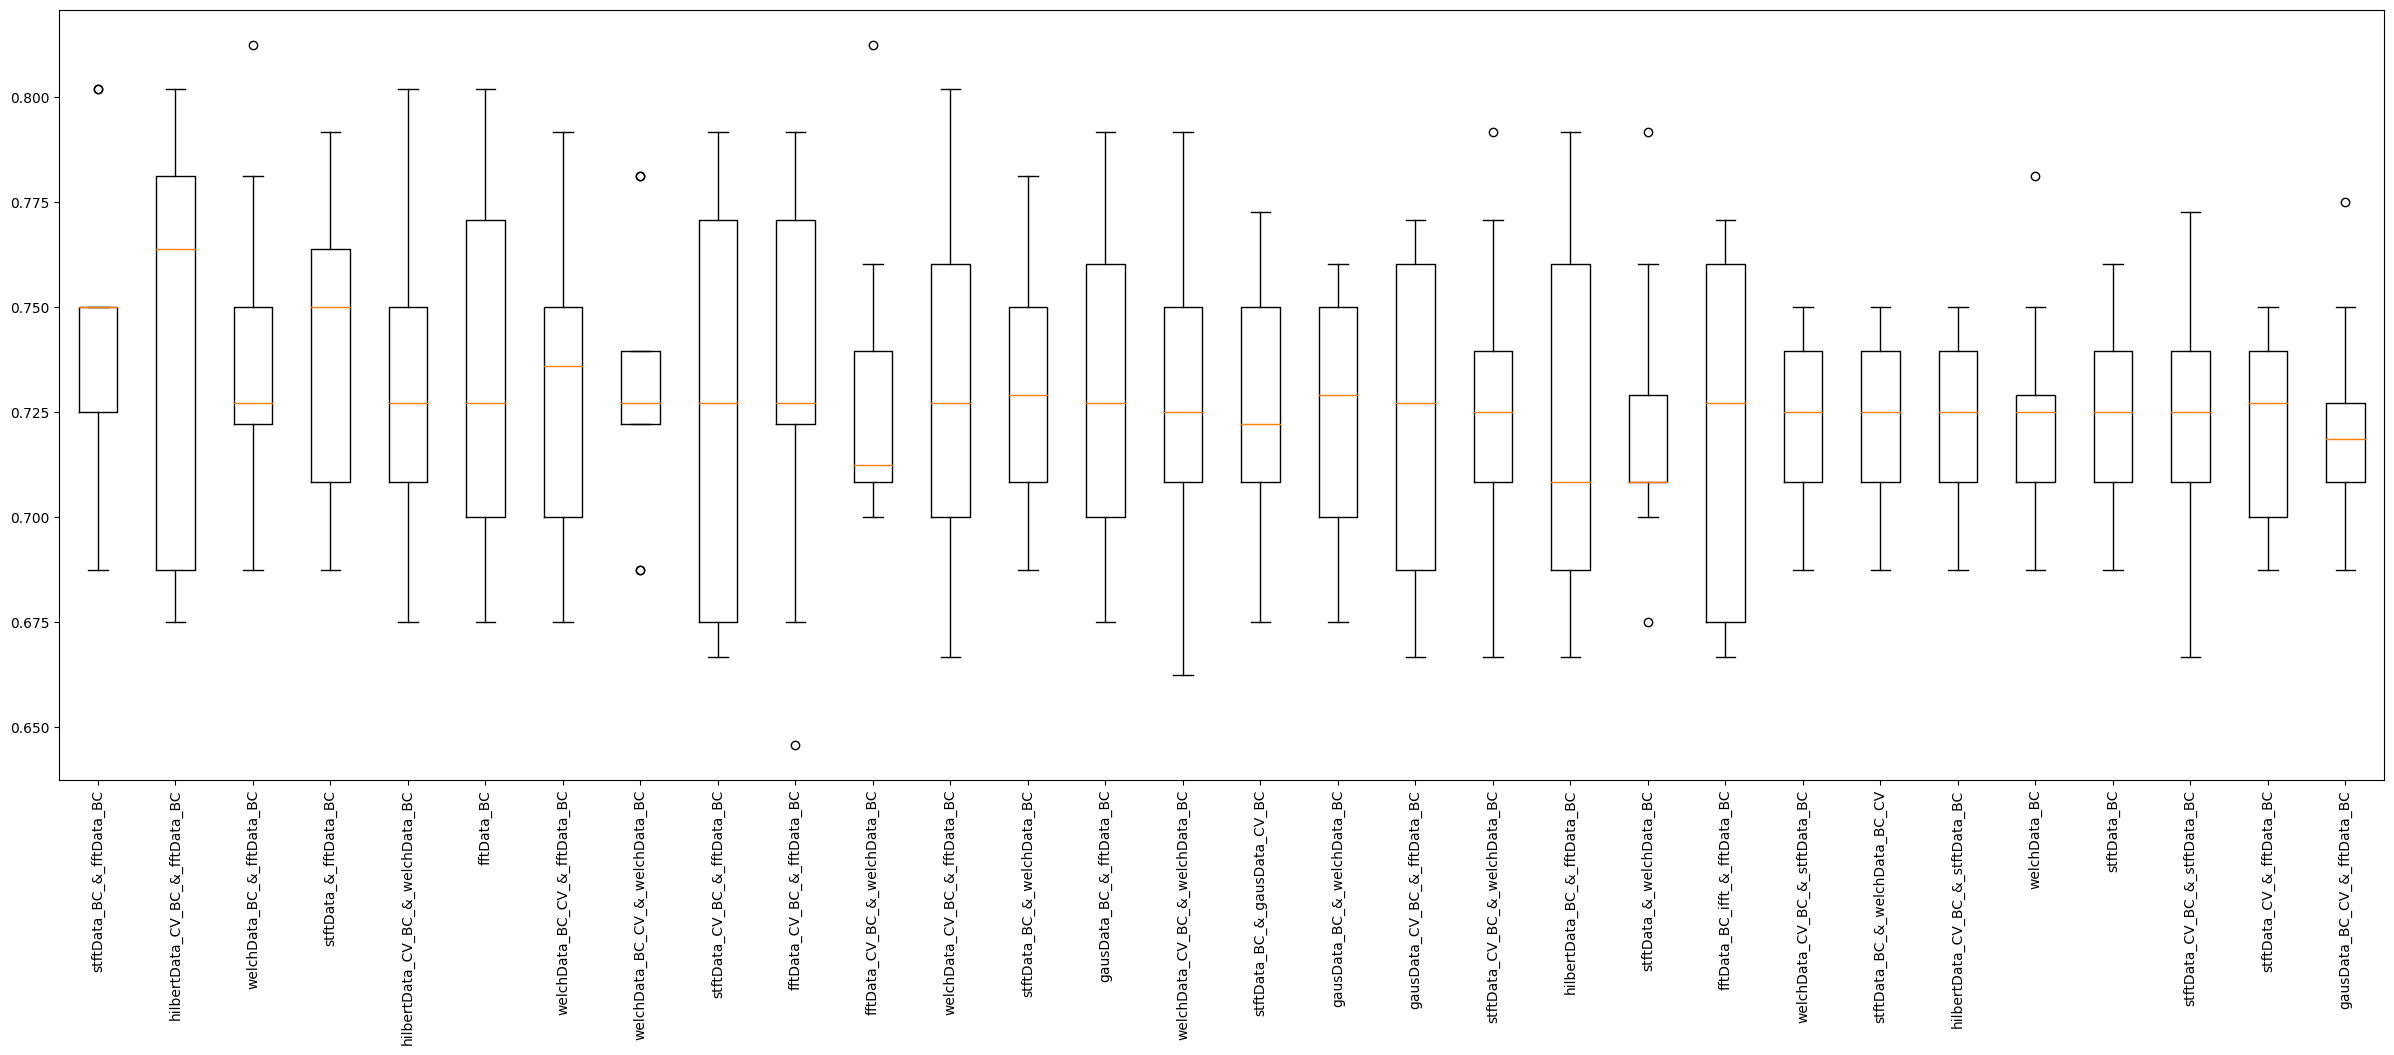

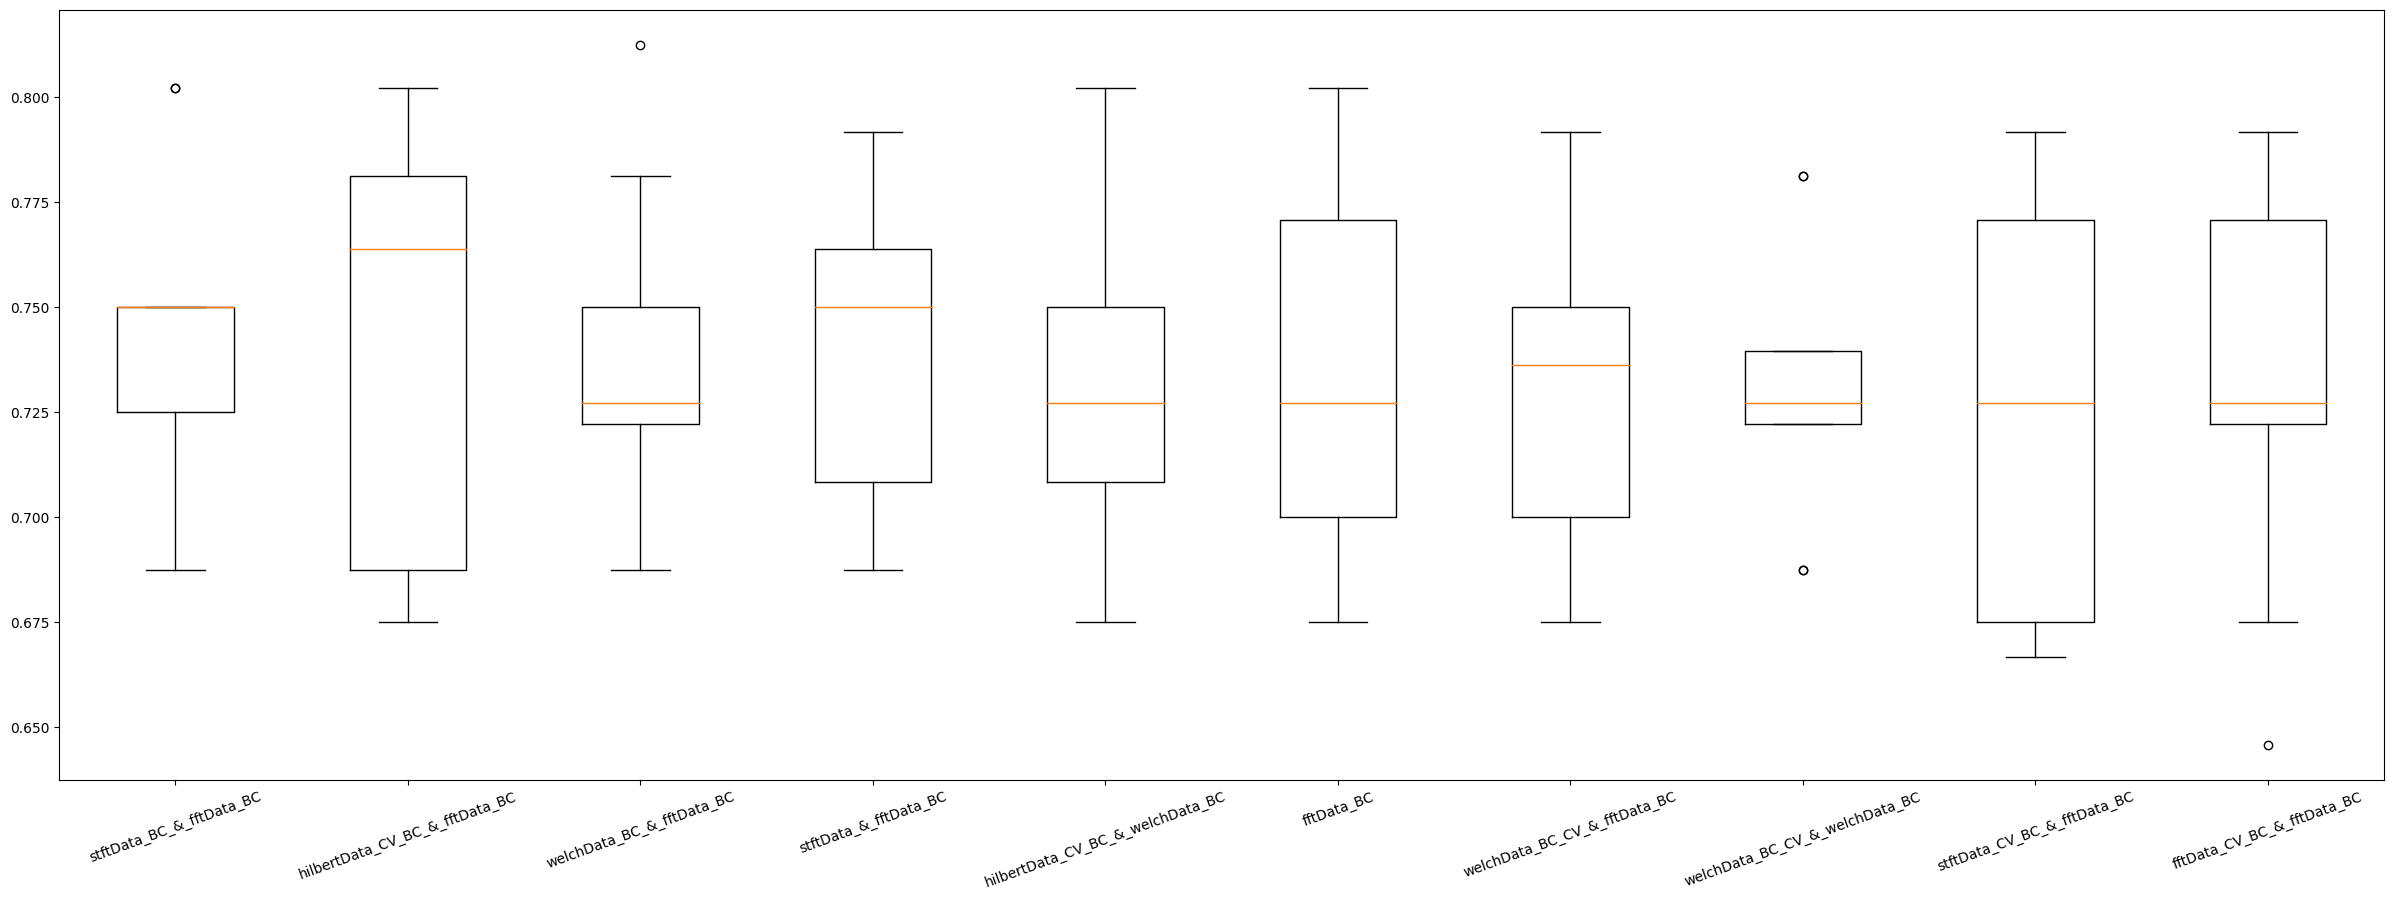

In [146]:
import matplotlib.pyplot as plt
meanTop = np.mean(topPerFeature[1:], axis=0)
indices = np.argsort(meanTop, axis=0)[::-1]

print(indices.shape)
featCombos = np.array(featCombos)

if len(featCombos) < 30:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(len(featCombos[indices][:30]))+1,featCombos[indices][:30],rotation=45)
    print("")
else: 
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(30)+1,featCombos[indices][:30],rotation=90)
    print("")
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:10])
    plt.xticks(np.arange(10)+1,featCombos[indices][:10],rotation=20)
    print("")
    


In [147]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.82 : subject 8, feature:gausData_BC_CV_&_fftData_BC_CV, kernellinear, C:0.1
Accuracy 0.81 : subject 2, feature:welchData_BC_&_fftData_BC, kernelrbf, C:5
Accuracy 0.81 : subject 2, feature:welchData_BC_&_fftData_BC, kernelrbf, C:2.5
Accuracy 0.81 : subject 2, feature:welchData_BC_&_fftData_BC, kernelrbf, C:10
Accuracy 0.81 : subject 2, feature:fftData_CV_BC_&_welchData_BC, kernellinear, C:0.1
Accuracy 0.8 : subject 2, feature:welchData_CV_BC_&_fftData_BC, kernelrbf, C:2.5
Accuracy 0.8 : subject 2, feature:stftData_BC_&_fftData_BC, kernelrbf, C:2.5
Accuracy 0.8 : subject 2, feature:hilbertData_CV_BC_&_fftData_BC, kernelrbf, C:5
Accuracy 0.8 : subject 2, feature:hilbertData_CV_BC_&_fftData_BC, kernelrbf, C:10
Accuracy 0.8 : subject 2, feature:fftData_BC, kernelrbf, C:5


In [148]:
print("Top ten highest accuracies")
for subTop in topThreeAllSubjects:
    subTop.reverse()

Top ten highest accuracies


In [149]:
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects[:-1]:
    print("")
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )

arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = np.array(topNames, dtype=object)
    skip = False  
    
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)



Accuracy 0.82 : subject 8, feature:gausData_BC_CV_&_fftData_BC_CV, kernellinear, C:0.1

Accuracy 0.81 : subject 2, feature:welchData_BC_&_fftData_BC, kernelrbf, C:5

Accuracy 0.8 : subject 5, feature:stftData_BC_&_fftData_BC, kernellinear, C:0.1

Accuracy 0.8 : subject 6, feature:gausData_CV_BC, kernelsigmoid, C:5

Accuracy 0.79 : subject 4, feature:stftData_&_welchData_BC, kernelrbf, C:2.5

Accuracy 0.77 : subject 9, feature:fftData_BC, kernelsigmoid, C:10

Accuracy 0.76 : subject 3, feature:stftData_&_fftData_BC, kernelrbf, C:5

Accuracy 0.75 : subject 7, feature:welchData_CV_BC_&_welchData_BC_CV, kernelsigmoid, C:2.5

Accuracy 0.72 : subject 1, feature:fftData_CV_BC_&_fftData_BC, kernelsigmoid, C:5
[array(['gausData_BC_CV', 'fftData_BC_CV'], dtype=object), array(['welchData_BC', 'fftData_BC'], dtype=object), array(['stftData_BC', 'fftData_BC'], dtype=object), array('gausData_CV_BC', dtype=object), array(['stftData', 'welchData_BC'], dtype=object), array('fftData_BC', dtype=object),

In [150]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])



[0.         0.5700253  0.63271761 0.60022492 0.63607456 0.62156714
 0.60715863 0.58423583 0.64686235 0.55706815]


,0,6,7,8,9,10,11,12,13,14,15,16,17,18,24,25,26,27,28,29,30,31,32,33,34,35,36,42,43,44,45,46,47,48,49,50,51,52,53,54,60,61,62,63,64,65,66,67,68,69,70,71,72,78,79,80,81,82,83,84,85,86,87,88,89,90,96,97,98,99,100,101,102,103,104,105,106,107,108,114,115,116,117,118,119,120,121,122,123,124,125,126,132,133,134,135,136,137,138,139,140,141,142,143,144,150,151,152,153,154,155,156,157,158,159,160,161,162,168,169,170,171,172,173,174,175,176,177,178,179,180,186,187,188,189,190,191,192,193,194,195,196,197,198,204,205,206,207,208,209,210,211,212,213,214,215,216,222,223,224,225,226,227,228,229,230,231,232,233,234,240,241,242,243,244,245,246,247,248,249,250,251,252,258,259,260,261,262,263,264,265,266,267,268,269,270,276,277,278,279,280,281,282,283,284,285,286,287,288,294,295,296,297,298,299,300,301,302,303,304,305,306,312,313,314,315,316,317,318,319,320,321,322,323,324,330,331,332,333,334,335,336,337,338,339,340,341,342,348,349,350,351,352,353,354,355,356,357,358,359,360,366,367,368,369,370,371,372,373,374,375,376,377,378,384,385,386,387,388,389,390,391,392,393,394,395,396,402,403,404,405,406,407,408,409,410,411,412,413,414,420,421,422,423,424,425,426,427,428,429,430,431,432,438,439,440,441,442,443,444,445,446,447,448,449,450,456,457,458,459,460,461,462,463,464,465,466,467,468,474,475,476,477,478,479,480,481,482,483,484,485,486,492,493,494,495,496,497,498,499,500,501,502,503,504,510,511,512,513,514,515,516,517,518,519,520,521,522,528,529,530,531,532,533,534,535,536,537,538,539,540,546,547,548,549,550,551,552,553,554,555,556,557,558,564,565,566,567,568,569,570,571,572,573,574,575,576,582,583,584,585,586,587,588,589,590,591,592,593,594,600,601,602,603,604,605,606,607,608,609,610,611,612,618,619,620,621,622,623,624,625,626,627,628,629,630,636,637,638,639,640,641,642,643,644,645,646,647,648,654,655,656,657,658,659,660,661,662,663,664,665,666,672,673,674,675,676,677,678,679,680,681,682,683,684,690,691,692,693,694,695,696,697,698,699,700,701,702,708,709,710,711,712,713,714,715,716,717,718,719,720,726,727,728,729,730,731,732,733,734,735,736,737,738,744,745,746,747,748,749,750,751,752,753,754,755,756,762,763,764,765,766,767,768,769,770,771,772,773,774,780,781,782,783,784,785,786,787,788,789,790,791,792,798,799,800,801,802,803,804,805,806,807,808,809,810,816,817,818,819,820,821,822,823,824,825,826,827,828,834,835,836,837,838,839,840,841,842,843,844,845,846,852,853,854,855,856,857,858,859,860,861,862,863,864,870,871,872,873,874,875,876,877,878,879,880,881,882,888,889,890,891,892,893,894,895,896,897,898,899,900,906,907,908,909,910,911,912,913,914,915,916,917,918,924,925,926,927,928,929,930,931,932,933,934,935,936,942,943,944,945,946,947,948,949,950,951,952,953,954,960,961,962,963,964,965,966,967,968,969,970,971,972,978,979,980,981,982,983,984,985,986,987,988,989,990,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1320,1321,1322,1323,1324,1325,1326,1327,1328

Max average accuracy 0.7183712121212121


In [151]:
print("Based on combAverage")
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    #print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combAverage
stftData_BC_&_fftData_BC
rbf
0.7183712121212121

hilbertData_CV_BC_&_fftData_BC
linear
0.7176206509539843

stftData_BC_&_fftData_BC
rbf
0.7155934343434345

hilbertData_CV_BC_&_welchData_BC
sigmoid
0.7124438832772166

welchData_CV_BC_&_fftData_BC
sigmoid
0.7117704826038159



In [152]:
print("Based on combTotal")
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combTotal
stftData_BC_&_fftData_BC
rbf
0.7183712121212121

hilbertData_CV_BC_&_fftData_BC
linear
0.7176206509539843

stftData_BC_&_fftData_BC
rbf
0.7155934343434345

hilbertData_CV_BC_&_welchData_BC
sigmoid
0.7124438832772166

welchData_CV_BC_&_fftData_BC
sigmoid
0.7117704826038159



In [153]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )
    print(allCombinations[maxInd2][0])
    print(allCombinations[maxInd2][1])
    print(f"C: {allCombinations[maxInd2][2]} ")


,0,6,7,8,9,10,11,12,13,14,15,16,17,18,24,25,26,27,28,29,30,31,32,33,34,35,36,42,43,44,45,46,47,48,49,50,51,52,53,54,60,61,62,63,64,65,66,67,68,69,70,71,72,78,79,80,81,82,83,84,85,86,87,88,89,90,96,97,98,99,100,101,102,103,104,105,106,107,108,114,115,116,117,118,119,120,121,122,123,124,125,126,132,133,134,135,136,137,138,139,140,141,142,143,144,150,151,152,153,154,155,156,157,158,159,160,161,162,168,169,170,171,172,173,174,175,176,177,178,179,180,186,187,188,189,190,191,192,193,194,195,196,197,198,204,205,206,207,208,209,210,211,212,213,214,215,216,222,223,224,225,226,227,228,229,230,231,232,233,234,240,241,242,243,244,245,246,247,248,249,250,251,252,258,259,260,261,262,263,264,265,266,267,268,269,270,276,277,278,279,280,281,282,283,284,285,286,287,288,294,295,296,297,298,299,300,301,302,303,304,305,306,312,313,314,315,316,317,318,319,320,321,322,323,324,330,331,332,333,334,335,336,337,338,339,340,341,342,348,349,350,351,352,353,354,355,356,357,358,359,360,366,367,368,369,370,371,372,373,374,375,376,377,378,384,385,386,387,388,389,390,391,392,393,394,395,396,402,403,404,405,406,407,408,409,410,411,412,413,414,420,421,422,423,424,425,426,427,428,429,430,431,432,438,439,440,441,442,443,444,445,446,447,448,449,450,456,457,458,459,460,461,462,463,464,465,466,467,468,474,475,476,477,478,479,480,481,482,483,484,485,486,492,493,494,495,496,497,498,499,500,501,502,503,504,510,511,512,513,514,515,516,517,518,519,520,521,522,528,529,530,531,532,533,534,535,536,537,538,539,540,546,547,548,549,550,551,552,553,554,555,556,557,558,564,565,566,567,568,569,570,571,572,573,574,575,576,582,583,584,585,586,587,588,589,590,591,592,593,594,600,601,602,603,604,605,606,607,608,609,610,611,612,618,619,620,621,622,623,624,625,626,627,628,629,630,636,637,638,639,640,641,642,643,644,645,646,647,648,654,655,656,657,658,659,660,661,662,663,664,665,666,672,673,674,675,676,677,678,679,680,681,682,683,684,690,691,692,693,694,695,696,697,698,699,700,701,702,708,709,710,711,712,713,714,715,716,717,718,719,720,726,727,728,729,730,731,732,733,734,735,736,737,738,744,745,746,747,748,749,750,751,752,753,754,755,756,762,763,764,765,766,767,768,769,770,771,772,773,774,780,781,782,783,784,785,786,787,788,789,790,791,792,798,799,800,801,802,803,804,805,806,807,808,809,810,816,817,818,819,820,821,822,823,824,825,826,827,828,834,835,836,837,838,839,840,841,842,843,844,845,846,852,853,854,855,856,857,858,859,860,861,862,863,864,870,871,872,873,874,875,876,877,878,879,880,881,882,888,889,890,891,892,893,894,895,896,897,898,899,900,906,907,908,909,910,911,912,913,914,915,916,917,918,924,925,926,927,928,929,930,931,932,933,934,935,936,942,943,944,945,946,947,948,949,950,951,952,953,954,960,961,962,963,964,965,966,967,968,969,970,971,972,978,979,980,981,982,983,984,985,986,987,988,989,990,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1320,1321,1322,1323,1324,1325,1326,1327,1328

551
9.0
Max total significant accuracy then averaged 0.7183712121212121 
welchData_BC_CV_&_fftData_BC
linear
C: 0.1 


In [154]:
for names in featCombos:
    print(names)



fftData_BC
welchData_BC
hilbertData_BC
fftData_BC_CV
welchData_BC_CV
hilbertData_BC_CV
gausData_CV_BC
gausData_BC
gausData_BC_CV
fftData_BC_ifft
fftData_BC_ifft_CV
stftData
stftData_BC
stftData_CV
stftData_BC_CV
fftData_CV_BC
welchData_CV_BC
hilbertData_CV_BC
stftData_CV_BC
welchData_BC_&_fftData_BC
hilbertData_BC_&_fftData_BC
fftData_BC_CV_&_fftData_BC
welchData_BC_CV_&_fftData_BC
hilbertData_BC_CV_&_fftData_BC
gausData_CV_BC_&_fftData_BC
gausData_BC_&_fftData_BC
gausData_BC_CV_&_fftData_BC
fftData_BC_ifft_&_fftData_BC
fftData_BC_ifft_CV_&_fftData_BC
stftData_&_fftData_BC
stftData_BC_&_fftData_BC
stftData_CV_&_fftData_BC
stftData_BC_CV_&_fftData_BC
fftData_CV_BC_&_fftData_BC
welchData_CV_BC_&_fftData_BC
hilbertData_CV_BC_&_fftData_BC
stftData_CV_BC_&_fftData_BC
hilbertData_BC_&_welchData_BC
fftData_BC_CV_&_welchData_BC
welchData_BC_CV_&_welchData_BC
hilbertData_BC_CV_&_welchData_BC
gausData_CV_BC_&_welchData_BC
gausData_BC_&_welchData_BC
gausData_BC_CV_&_welchData_BC
fftData_BC_ifft_&

: 